# Truth analysis of the ACTS data

In this notebook I will make truth distributions of the data
and come up with some preliminary trigger algorithm to target.

In [16]:
# System
from __future__ import print_function
from __future__ import division
import os
import multiprocessing as mp

# Externals
import numpy as np
import pandas as pd

# Locals
from data import process_files, select_barrel_hits

# Plotting
import matplotlib.pyplot as plt

%matplotlib notebook

## Load data

In [2]:
# Config
input_dir = '/global/cscratch1/sd/sfarrell/ACTS/prod_mu10_pt1000_2017_07_29'
n_files = 1
n_workers = 1

all_files = os.listdir(input_dir)
hits_files = sorted(f for f in all_files if f.startswith('clusters'))
hits_files = [os.path.join(input_dir, f) for f in hits_files[:n_files]]
particles_files = sorted(f for f in all_files if f.startswith('particles'))
particles_files = [os.path.join(input_dir, f) for f in particles_files[:n_files]]

In [3]:
%%time

with mp.Pool(processes=n_workers) as pool:
    hits, particles = process_files(hits_files, particles_files, pool)
    hits = pool.map(select_barrel_hits, hits)

hits = pd.concat(hits)
particles = pd.concat(particles)

Loading /global/cscratch1/sd/sfarrell/ACTS/prod_mu10_pt1000_2017_07_29/clusters_1.csv
Loading /global/cscratch1/sd/sfarrell/ACTS/prod_mu10_pt1000_2017_07_29/particles_1.csv
CPU times: user 61.6 ms, sys: 105 ms, total: 167 ms
Wall time: 1min 7s


## All particles distributions

<IPython.core.display.Javascript object>


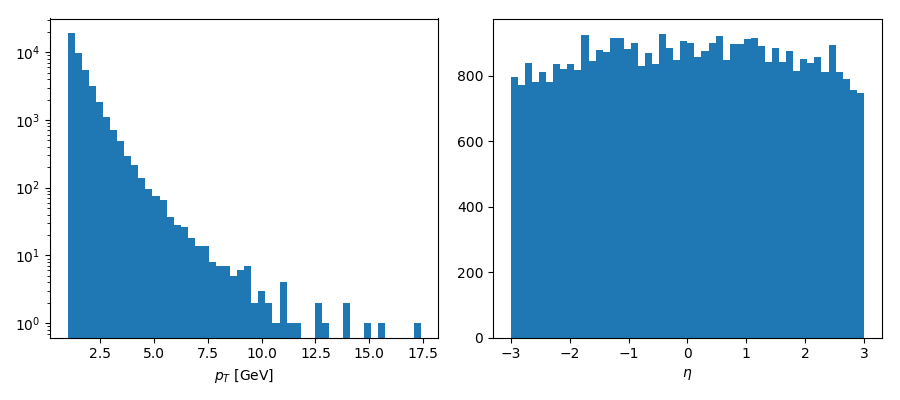

In [4]:
# Plot the distributions of all particles
plt.figure(figsize=(9,4))
plt.subplot(121)
plt.hist(particles.pt, bins=50, log=True)
plt.xlabel('$p_T$ [GeV]')
plt.subplot(122)
plt.hist(particles.eta, bins=50)
plt.xlabel('$\eta$')
plt.tight_layout()

<IPython.core.display.Javascript object>


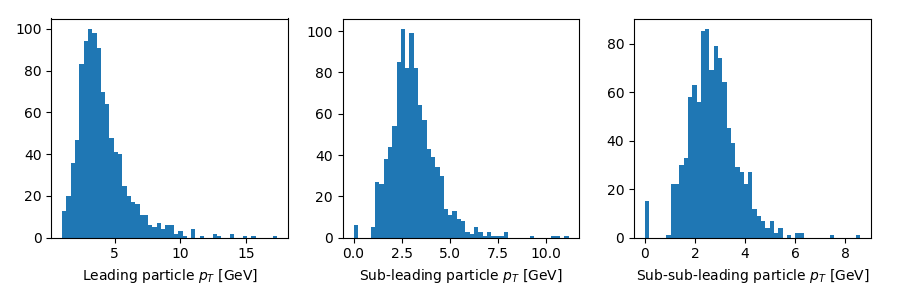

In [5]:
# Plot the 2 highest pt particles in each event
g = particles.groupby('evtid')
pt1 = g['pt'].agg(np.max)
pt2 = g.apply(lambda x: 0 if len(x) < 2 else x.pt.sort_values().iloc[-2])
pt3 = g.apply(lambda x: 0 if len(x) < 3 else x.pt.sort_values().iloc[-3])

plt.figure(figsize=(9,3))
plt.subplot(131)
plt.hist(pt1, bins=50)
plt.xlabel('Leading particle $p_T$ [GeV]')
plt.subplot(132)
plt.hist(pt2, bins=50)
plt.xlabel('Sub-leading particle $p_T$ [GeV]')
plt.subplot(133)
plt.hist(pt3, bins=50)
plt.xlabel('Sub-sub-leading particle $p_T$ [GeV]')
plt.tight_layout()

In [6]:
# This is close to half; might be a good starting point
(pt2 > 3).mean()

0.49298597194388777

### Particle counts vs pt thresholds

<IPython.core.display.Javascript object>


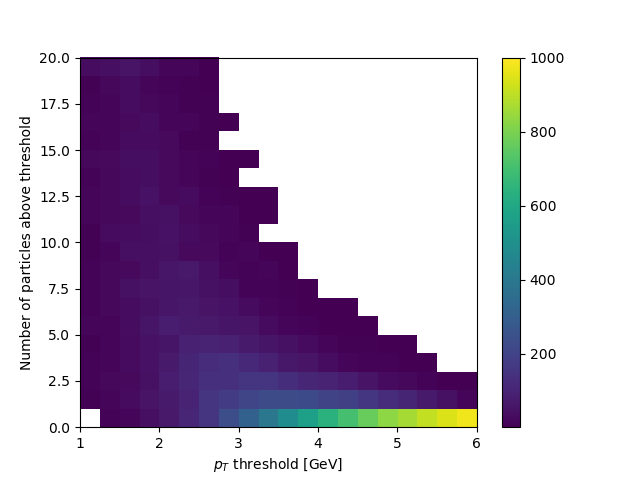

In [7]:
pt_bins = 20
pt_range = (1, 6)
count_bins = 20
count_range = (0, 20)
pt_threshs = np.linspace(pt_range[0], pt_range[1], pt_bins, endpoint=False)

# Bin and reverse cumsum
cumthresh = lambda x: np.histogram(x.pt, bins=pt_bins, range=pt_range)[0][::-1].cumsum()[::-1]

c = np.concatenate(g.apply(cumthresh).values)
x = np.tile(pt_threshs, g.ngroups)

plt.figure()
plt.hist2d(x, c, bins=(pt_bins, count_bins), range=(pt_range, count_range), cmin=1, vmax=1000)
plt.xlabel('$p_T$ threshold [GeV]')
plt.ylabel('Number of particles above threshold')
plt.colorbar();

### Reconstructable particles only

What about reconstructable particles? Presumably the number of good measurable tracks above threshold is lower. Maybe I should define a criteria for reconstructable.

Let's start by looking at the 3GeV particles and seeing how many hits they have.

In [8]:
# How many layers does each particle hit?
join_keys = ['evtid', 'barcode']
nlayer = (hits.groupby(join_keys).apply(lambda x: len(x.layer.unique()))
          .reset_index(name='nlayer'))
pars = particles.merge(nlayer, on=join_keys)

In [9]:
pars.nlayer.describe()

count    42679.000000
mean         6.225896
std          3.417938
min          1.000000
25%          2.000000
50%          7.000000
75%         10.000000
max         10.000000
Name: nlayer, dtype: float64

In [10]:
# Reconstructable particles hit at least 7 barrel layers
reco_layer_threshold = 7
reco_pars = pars[pars.nlayer >= 7]

In [11]:
def get_pt_vars(x, k=5):
    pt = np.zeros(k)
    cols = ['pt%i'%i for i in range(k)]
    n = min(k, len(x))
    pt[:n] = x.pt.sort_values()[::-1][:n]
    return pd.Series(pt, index=cols)

In [12]:
reco_events = reco_pars.groupby('evtid')
events_pt = reco_events.apply(get_pt_vars)

<IPython.core.display.Javascript object>


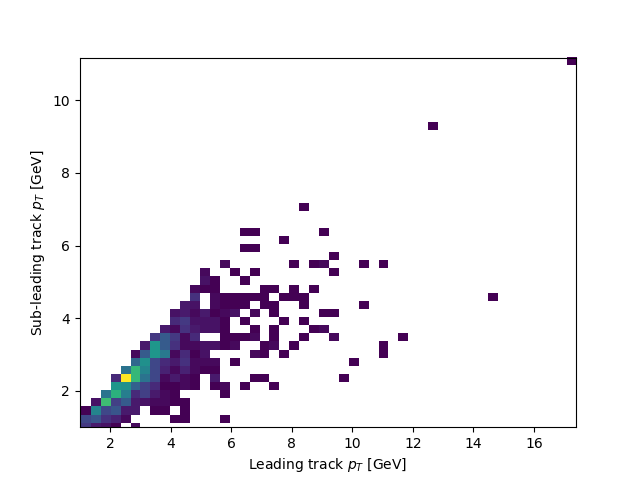

In [13]:
plt.figure()
plt.hist2d(events_pt.pt0, events_pt.pt1, bins=50, cmin=1)
plt.xlim(xmin=1)
plt.ylim(ymin=1)
plt.xlabel('Leading track $p_T$ [GeV]')
plt.ylabel('Sub-leading track $p_T$ [GeV]')

In [15]:
# Here's a good candidate trigger target
(events_pt.pt3 > 2).mean()

0.49292929292929294